In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, GRU,LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [49]:
df=pd.read_csv('./HDFC.csv',index_col='Date',parse_dates=True)

In [50]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,HDFC,EQ,271.75,293.50,293.50,293.50,293.50,293.50,293.50,22744,6.675364e+11,NaN,NaN,NaN
2000-01-04,HDFC,EQ,293.50,317.00,317.00,297.00,304.00,304.05,303.62,255251,7.749972e+12,NaN,NaN,NaN
2000-01-05,HDFC,EQ,304.05,290.00,303.90,285.00,295.00,292.80,294.53,269087,7.925368e+12,NaN,NaN,NaN
2000-01-06,HDFC,EQ,292.80,301.00,314.00,295.00,296.00,296.45,300.14,305916,9.181669e+12,NaN,NaN,NaN
2000-01-07,HDFC,EQ,296.45,290.00,296.35,281.00,287.10,286.55,288.80,197039,5.690480e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,HDFC,EQ,2497.35,2500.00,2534.10,2483.20,2502.00,2509.80,2508.07,3916088,9.821805e+14,121028.0,2440395.0,0.6232
2021-04-27,HDFC,EQ,2509.80,2494.15,2526.80,2486.25,2514.00,2518.40,2509.18,2040799,5.120730e+14,102250.0,1040749.0,0.5100
2021-04-28,HDFC,EQ,2518.40,2516.10,2609.00,2508.30,2575.00,2577.00,2574.21,3407461,8.771527e+14,117425.0,1815110.0,0.5327


In [51]:
df['Date']=df.index

In [52]:
start_date='2020-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [53]:
df=df.loc[mask]

In [54]:
df=df.loc[mask]

In [55]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [56]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [57]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [58]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [59]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (201, 50) Y.shape (201,)


In [60]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

Bi-LSTM

In [61]:
i=Input(shape=(T,1))
x=Bidirectional(LSTM(200,return_sequences=True))(i)
x=Bidirectional(LSTM(200,return_sequences=True))(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_bi_lstm=Model(i,x)
model_bi_lstm.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 50, 400)          323200    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 50, 400)          961600    
 nal)                                                            
                                                                 
 global_max_pooling1d_4 (Glo  (None, 400)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 100)               40100     
                                                           

In [62]:
check_point_bi_lstm=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [63]:
model_bi_lstm.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [64]:
r=model_bi_lstm.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_bi_lstm]
)

Epoch 1/100
4/4 [==============================] - 12s 1s/step - loss: 4455.4854 - mae: 46.1690 - mse: 4455.4854 - val_loss: 1973.9777 - val_mae: 32.9207 - val_mse: 1973.9777
Epoch 2/100
4/4 [==============================] - 3s 775ms/step - loss: 4402.2788 - mae: 45.7610 - mse: 4402.2788 - val_loss: 1893.1577 - val_mae: 32.2673 - val_mse: 1893.1577
Epoch 3/100
4/4 [==============================] - 3s 770ms/step - loss: 4386.1914 - mae: 45.7671 - mse: 4386.1914 - val_loss: 1874.7538 - val_mae: 32.1075 - val_mse: 1874.7538
Epoch 4/100
4/4 [==============================] - 3s 776ms/step - loss: 4380.8896 - mae: 45.7012 - mse: 4380.8896 - val_loss: 1870.6798 - val_mae: 32.0740 - val_mse: 1870.6798
Epoch 5/100
4/4 [==============================] - 3s 752ms/step - loss: 4372.4106 - mae: 45.6572 - mse: 4372.4106 - val_loss: 1884.1562 - val_mae: 32.1943 - val_mse: 1884.1562
Epoch 6/100
4/4 [==============================] - 3s 737ms/step - loss: 4366.8521 - mae: 45.6072 - mse: 4366.8521 - 

Bi-directional GRU

In [65]:
i=Input(shape=(T,1))
x=Bidirectional(GRU(200,return_sequences=True))(i)
x=Bidirectional(GRU(200,return_sequences=True))(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_bi_gru=Model(i,x)
model_bi_gru.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 50, 400)          243600    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 50, 400)          722400    
 onal)                                                           
                                                                 
 global_max_pooling1d_5 (Glo  (None, 400)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_15 (Dense)            (None, 100)               40100     
                                                           

In [66]:
check_point_bi_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [67]:
model_bi_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [68]:
r=model_bi_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_bi_gru]
)

Epoch 1/100
4/4 [==============================] - 12s 1s/step - loss: 4489.1260 - mae: 46.5347 - mse: 4489.1260 - val_loss: 2027.6312 - val_mae: 33.3741 - val_mse: 2027.6312
Epoch 2/100
4/4 [==============================] - 2s 647ms/step - loss: 4409.5806 - mae: 45.7827 - mse: 4409.5806 - val_loss: 1881.5216 - val_mae: 32.1649 - val_mse: 1881.5216
Epoch 3/100
4/4 [==============================] - 2s 651ms/step - loss: 4385.7817 - mae: 45.8391 - mse: 4385.7817 - val_loss: 1853.9139 - val_mae: 31.9662 - val_mse: 1853.9139
Epoch 4/100
4/4 [==============================] - 2s 629ms/step - loss: 4377.0957 - mae: 45.7538 - mse: 4377.0957 - val_loss: 1855.6621 - val_mae: 31.9859 - val_mse: 1855.6621
Epoch 5/100
4/4 [==============================] - 2s 633ms/step - loss: 4363.6235 - mae: 45.6772 - mse: 4363.6235 - val_loss: 1887.2327 - val_mae: 32.2188 - val_mse: 1887.2327
Epoch 6/100
4/4 [==============================] - 2s 618ms/step - loss: 4353.5742 - mae: 45.5468 - mse: 4353.5742 - 

Predictions

In [69]:
train_idx[:T+1]=False

In [70]:
Ptrain_bi_lstm=model_bi_lstm.predict(Xtrain).flatten()
Ptest_bi_lstm=model_bi_lstm.predict(Xtest).flatten()

In [71]:
Ptrain_bi_gru=model_bi_gru.predict(Xtrain).flatten()
Ptest_bi_gru=model_bi_gru.predict(Xtest).flatten()

In [72]:
df.loc[train_idx,'Diff Bi-LSTM train prediction']=Ptrain_bi_lstm
df.loc[test_idx,'Diff bi-LSTM test prediction']=Ptest_bi_lstm

In [73]:
df.loc[train_idx,'Diff Bi-GRU train prediction']=Ptrain_bi_gru
df.loc[test_idx,'Diff BiGRU test prediction']=Ptest_bi_gru

In [74]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [75]:
last_train=train.iloc[-1]['Prev Close']

In [76]:
df.loc[train_idx,'train_Bi_LSTM']=prev[train_idx]+Ptrain_bi_lstm
df.loc[test_idx,'Prediction_Bi_LSTM']=prev[test_idx]+Ptest_bi_lstm

In [77]:
df.loc[train_idx,'train_Bi_GRU']=prev[train_idx]+Ptrain_bi_gru
df.loc[test_idx,'Prediction_Bi_GRU']=prev[test_idx]+Ptest_bi_gru

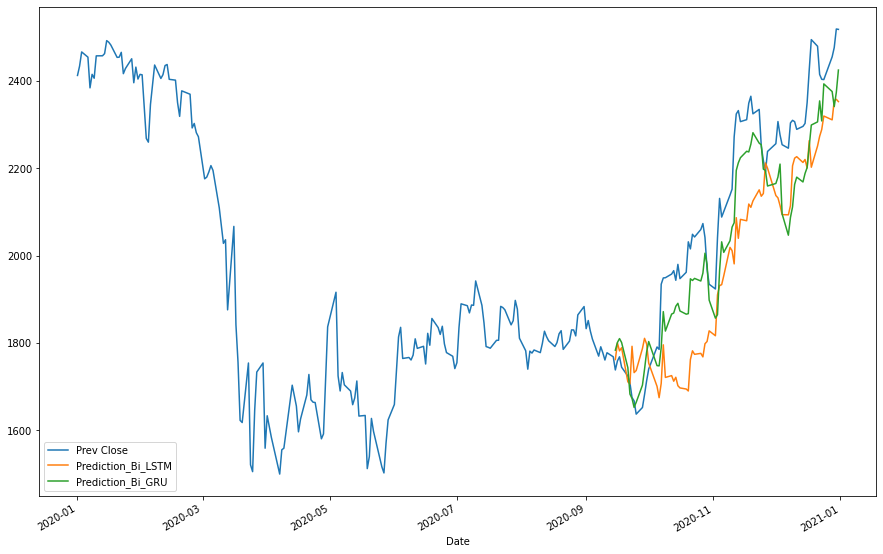

In [78]:
df[[ 'Prev Close','Prediction_Bi_LSTM','Prediction_Bi_GRU']].plot(figsize=(15,10));

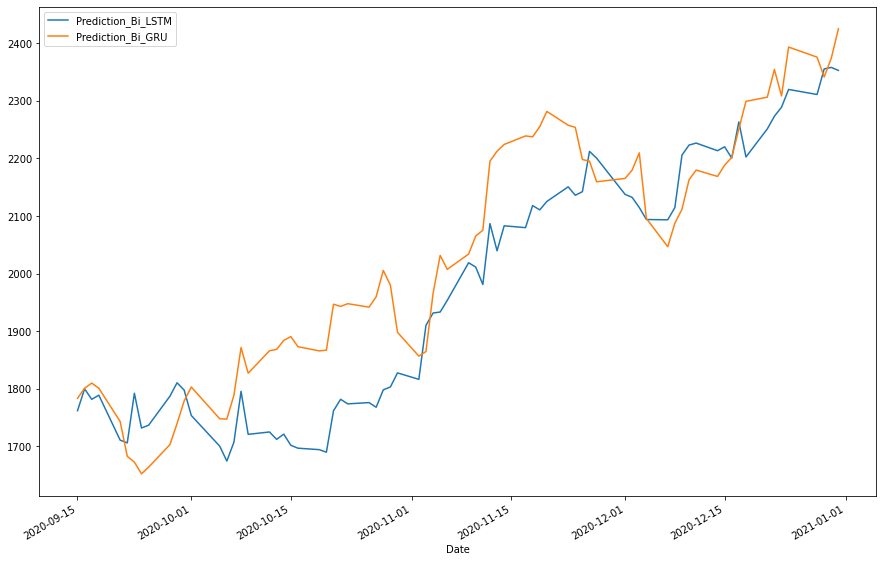

In [79]:
df[[ 'Prediction_Bi_LSTM','Prediction_Bi_GRU']].plot(figsize=(15,10));

Evaluation

In [80]:
pred_bi_lstm=df['Prediction_Bi_LSTM']
pred_bi_lstm.dropna(inplace=True)

In [81]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_bi_lstm))
print(rmse)

178.69795721335865


In [82]:
error=mean_absolute_error(test['Prev Close'],pred_bi_lstm)
print(error)

158.18091179402668


In [83]:
r2_score(test['Prev Close'],pred_bi_lstm)

0.499715358624539

In [84]:
pred_bi_gru=df['Prediction_Bi_GRU']
pred_bi_gru.dropna(inplace=True)

In [85]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_bi_gru))
print(rmse)

105.81324501622962


In [86]:
error=mean_absolute_error(test['Prev Close'],pred_bi_gru)
print(error)

91.40012896728516


In [87]:
r2_score(test['Prev Close'],pred_bi_gru)

0.8245885005112757